Team,

I've produced clean data for folks to work with downstream, and provided some preliminary sketches of how the data can be used.  Scan thru the notebook to see what the dataframes look like....

<b>youtube_data</b>: US data downloaded from youtube and cleaned<br><br>
<b>pub_by_date</b>: Videos published by date.  I made a line graph. I can also group them by day of week if you'd like.<br><br>
<b>categories</b>: Vids grouped by category with number, likes and dislikes.  Can make plots / inferences.<br><br>
<b>month_stats</b>: Data by months--published, trending, views<br><br>
<b>lag_data</b>: days it takes videos to trend.  Nice histogram with single outlier that we could find and remove.

I've also done the user input thing at the end.

Most of the work was brute-force data cleaning, and therefore not very interesting.  However, some learning:

<i>1) The datetime type allows you to manipulate dates with ease.  Not covered in class but powerful.  See the description in cell In[4].</i><br><br>
<i>2) Lots of duplicate videos.  Folks post the same video multiple times from the same account.  Dropped these.  If I want to be more sophisticated, I'd loop thru videos by name, and total all of the video statistics for all repeats.  Maybe will do that this week to further clean up the data.</i>

Let me know if there is other data you'd like me to produce.  I'll start helping with the MatPlotLib and API folks now.

--Tom


In [1]:
%matplotlib notebook
%matplotlib inline 

In [17]:
# Load packages
from matplotlib import pyplot as plt
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
import functools as ft
import seaborn as sns
import re  
from scipy.stats import logistic
import calendar
import random

In [3]:
# Load data
youtube_data = pd.read_csv('US_youtube_trending_data.csv')
lookup = pd.read_csv('category_ids.csv')


In [4]:
# Function to parse dates (there is probably a built-in function, but this is what I was able to figure out)

def youtube_date_parse(df, series_to_parse, new_name_date, new_name_time, delimiting_character, drop_character):
    try:
        split = df[series_to_parse].str.split(delimiting_character, n = 1, expand = True)
        split[1] =split[1].map(lambda x: x.rstrip(drop_character))
        df[new_name_date] = split[0]
        df[new_name_time] = split[1]
        df.drop(columns = [series_to_parse], inplace=True)
        df[new_name_date] = pd.to_datetime(df[new_name_date])
        return df
    except:
        print('Already parsed, dumbass...')
        
        

In [5]:
########### Clean up data: drop columns, parse dates, replace category numbers with cateogry names, etc. #####

# Drop unneeded columns
youtube_data.drop(['video_id','channelId', 'thumbnail_link', 'comments_disabled', 'ratings_disabled'],\
                  axis=1, inplace = True)

# Convert date strings to datetime objects
youtube_date_parse(youtube_data, 'publishedAt', 'date_published', 'time_published', 'T', 'Z')
youtube_date_parse(youtube_data, 'trending_date', 'date_trending', 'time_trending', 'T', 'Z')
youtube_data.drop(['time_trending'], axis=1, inplace=True)

# The datetime functions are great, and can be used to group (see below).
# To make life easier for folks, I'm going to put month names in their own column
# notice the .dt.month syntax that works on datetime objects
youtube_data['month_published']= youtube_data['date_published'].dt.month
youtube_data['month_trending'] = youtube_data['date_trending'].dt.month
youtube_data['month_published'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)
youtube_data['month_trending'].replace([8,9,10,11], ['Aug', 'Sept', 'Oct', 'Nov'], inplace=True)

# Calculate lag time between posting and trending.  You can do arithmetic with dates in datetime
youtube_data['lag'] = youtube_data['date_trending'] - youtube_data['date_published']

# Covert category IDs to catetory names
youtube_data['categoryId'].replace(lookup['categoryId'].tolist(), lookup['category'].tolist(), inplace=True)

# Rename columns
new_names = {'channelTitle':'channel', 'categoryId':'category', 'view_count':'views', 'comment_count':'comments'}
youtube_data.rename(columns = new_names, inplace=True)

# Sort by likes
youtube_data.sort_values('likes', ascending=False, inplace=True)


# Reorder columns for readability
new_order = ['channel', 'title', 'category', 'views', 'likes','dislikes','comments', 'date_published', 'date_trending','lag','month_published', 'month_trending', 'time_published','tags', 'description']
youtube_data=youtube_data[new_order]

# Get column names so they are handy
cols = youtube_data.columns

# Keep only the most popular posting of duplicate videos
# I could maybe try to roll the stats for duplicates together,
# but this is tricky, in that they will have different dates.
youtube_data = youtube_data.drop_duplicates(subset='title', keep='first')
youtube_data.head()


,channel,title,category,views,likes,dislikes,comments,date_published,date_trending,lag,month_published,month_trending,time_published,tags,description
3358,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV,Music,232649205,15735533,714194,6065230,2020-08-21,2020-08-28,7 days,Aug,Aug,03:58:10,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MVCredits:Dire...
4980,BLACKPINK,BLACKPINK - 'Ice Cream (with Selena Gomez)' M/V,Music,184778248,11795670,879354,2735997,2020-08-28,2020-09-05,8 days,Aug,Sept,04:00:11,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK - ‘Ice Cream (with Selena Gomez)’Com...
11764,BLACKPINK,BLACKPINK – ‘Lovesick Girls’ M/V,Music,140685439,9217876,127308,1507605,2020-10-02,2020-10-09,7 days,Oct,Oct,04:00:13,YG Entertainment|YG|와이지|K-pop|BLACKPINK|블랙핑크|블...,BLACKPINK – ‘Lovesick Girls’영원한 밤창문 없는 방에 우릴 가...
2762,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official Teaser,Music,62496726,6178664,158845,992356,2020-08-18,2020-08-25,7 days,Aug,Aug,15:00:02,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official TeaserBTS (방탄소...
3992,Big Hit Labels,BTS (방탄소년단) 'Dynamite' Official MV (B-side),Music,45596902,5951286,97683,382374,2020-08-24,2020-08-31,7 days,Aug,Aug,15:00:01,BIGHIT|빅히트|방탄소년단|BTS|BANGTAN|방탄,BTS (방탄소년단) 'Dynamite' Official MV (B-side)Cre...


In [6]:
# See how many videos were published each day in the dataset
# Remember, the youtube data set is a subset of of trending videos in the US, not all videos
pub_by_date = youtube_data[['title', 'date_published']].groupby('date_published')\
.count().rename(columns={'title':'number_published'})
pub_by_date

,number_published
date_published,
2020-08-03,1
2020-08-05,4
2020-08-06,22
2020-08-07,34
2020-08-08,29
...,...
2020-11-01,27
2020-11-02,38
2020-11-03,13


(array([737638., 737652., 737669., 737683., 737699., 737713., 737730.]),
 <a list of 7 Text major ticklabel objects>)

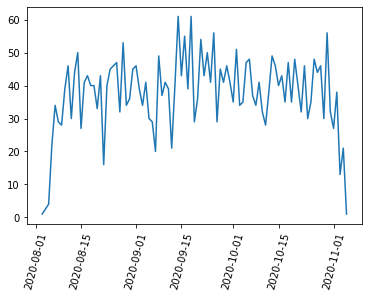

In [7]:
# And plot the number published each day
# I could see if there are trends by days of the week
plt.plot(pub_by_date['number_published'])
plt.xticks(rotation=75)

In [9]:
# Categories looks at total published, likes, and dislikes.
# Only the news and politics have significant dislikes
categories = youtube_data[['category', 'title']].groupby('category').count().rename(columns={'title':'number_published'}).sort_values('number_published', ascending=False)


categories['likes'] = youtube_data[['category', 'likes']].groupby('category').sum()
categories['dislikes'] = youtube_data[['category', 'dislikes']].groupby('category').sum()
#opinions = pd.merge(likes, dislikes, on="category")

categories['total_opinions'] = categories['likes'] + categories['dislikes'] 
categories['% like'] = (categories['likes'] / categories['total_opinions']).map("{:.2%}".format)
categories['% dislike'] = (categories['dislikes'] / categories['total_opinions']).map("{:.2%}".format)

print('categories:')
categories

categories:


,number_published,likes,dislikes,total_opinions,% like,% dislike
category,,,,,,
Music,801,254239406,6688126,260927532,97.44%,2.56%
Entertainment,657,103303685,2091086,105394771,98.02%,1.98%
Sports,504,15862292,569669,16431961,96.53%,3.47%
Gaming,317,47113552,1322594,48436146,97.27%,2.73%
People & Blogs,273,36294827,1085630,37380457,97.10%,2.90%
Comedy,212,29566307,340045,29906352,98.86%,1.14%
Science & Technology,180,15725993,597019,16323012,96.34%,3.66%
News & Politics,158,3223871,556373,3780244,85.28%,14.72%
Howto & Style,151,11417546,347035,11764581,97.05%,2.95%


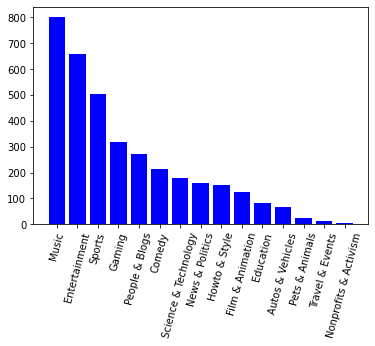

In [10]:
# Plot number of vids in each category
# Someone could add the x labels.  I'm bad at it.
x_axis = categories.index
y_axis = categories['number_published']
plt.bar(x_axis, y_axis, color='b' )
plt.xticks(rotation=75)
plt.show()

In [11]:
# See if there are any trends by month.
# There are not.

month_stats = youtube_data[['date_published', 'title']].groupby(pd.Grouper(key='date_published',freq='M')).count()\
.rename(columns={'title':'published'})
month_stats['trending'] = youtube_data[['date_trending', 'title']].groupby(pd.Grouper(key='date_trending',freq='M')).count()
month_stats['views'] = youtube_data[['date_published', 'views']].groupby(pd.Grouper(key='date_published',freq='M')).sum()
print('month_stats:')
month_stats.set_index(pd.Index(['Aug', 'Sept', 'Oct', 'Nov']))

month_stats:


,published,trending,views
Aug,988,783,2942488874
Sept,1236,1221,3239138144
Oct,1242,1239,3753111791
Nov,100,323,172017030


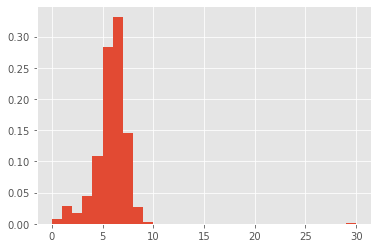

In [123]:
# See how long it takes a video to trend.
# We have a single outlier at 30 days, which we could chop off in subsequent work.

lag_data = youtube_data['lag'].dt.days
plt.hist(lag_data, density=True, bins=30)
plt.show()

In [12]:
# Produce the most popular videos for a user

answer = 'Y'
while answer == 'Y':
    month = input('\n\nMonth for most liked videos (Aug, Sept, Oct, Nov)?')
    number = int(input('How many videos to see?'))
    month_data = youtube_data.loc[youtube_data['month_published']==month]
    month_sorted = month_data.sort_values('likes', ascending=False)
    print('Most popular videos:')
    vids = month_sorted.iloc[0:number,:]
    print(vids['title'])
    answer = input('Continue Y/N?')



Month for most liked videos (Aug, Sept, Oct, Nov)?aug
How many videos to see?1
Most popular videos:
Series([], Name: title, dtype: object)
Continue Y/N?n


In [81]:
#Des' Prep
#df of the top 100
df=youtube_data
df_top100=df.sort_values(by='views', ascending=False)
df_top100=df_top100.head(100)

In [54]:
#Des' Prep
#percentage of likes and dislikes
df = youtube_data

df['tot_reaction'] = df['likes'] + df['dislikes'] + df['comments']
df['tot_sentements'] = df['likes'] + df['dislikes']
df['per_likes'] = round((df['likes']/df['tot_sentements']),2)
df['per_dislikes'] = round((df['dislikes']/df['tot_sentements']), 2)
youtube_data=df 

3358     0.96
4980     0.93
11764    0.99
2762     0.97
3992     0.98
         ... 
14402     NaN
7659      NaN
7691      NaN
7724      NaN
9124      NaN
Name: per_likes, Length: 3566, dtype: float64

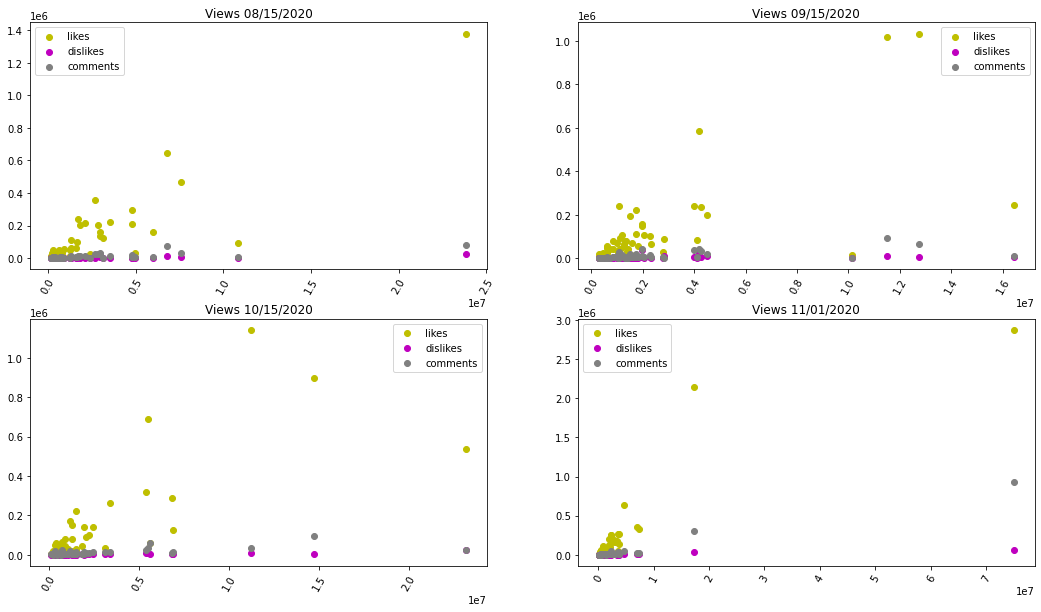

In [61]:
#Scatter Plots of likes and dislikes on a date from all four months based on views
#August starts on the 13th, full month of Sept and Oct, Nov is only 1-5th

#input_date = input(f'Enter a date to see what was trending that day example month/day/year')
#date=df[df['date_trending']==input_date]

#subplots initilizer
fig, (ax) = plt.subplots(2, figsize=(18, 10))
#supplot 1
#initialize
df = youtube_data
#filter
df=df[df['date_trending']=='08/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 1)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='gray')
ax.set(title='Views 08/15/2020')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 2
#initialize
df = youtube_data
#filter
df=df[df['date_trending']=='09/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 2)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='gray')
ax.set(title='Views 09/15/2020')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 3
#initialize
df = youtube_data
#filter
df=df[df['date_trending']==' 10/15/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 3)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='gray')
ax.set(title='Views 10/15/2020')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 4
#initialize
df = youtube_data
#filter
df=df[df['date_trending']==' 11/01/2020']
#subplot (rows, columns, locate)
ax = plt.subplot(2, 2, 4)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='gray')
ax.set(title='Views 11/01/2020')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.show()

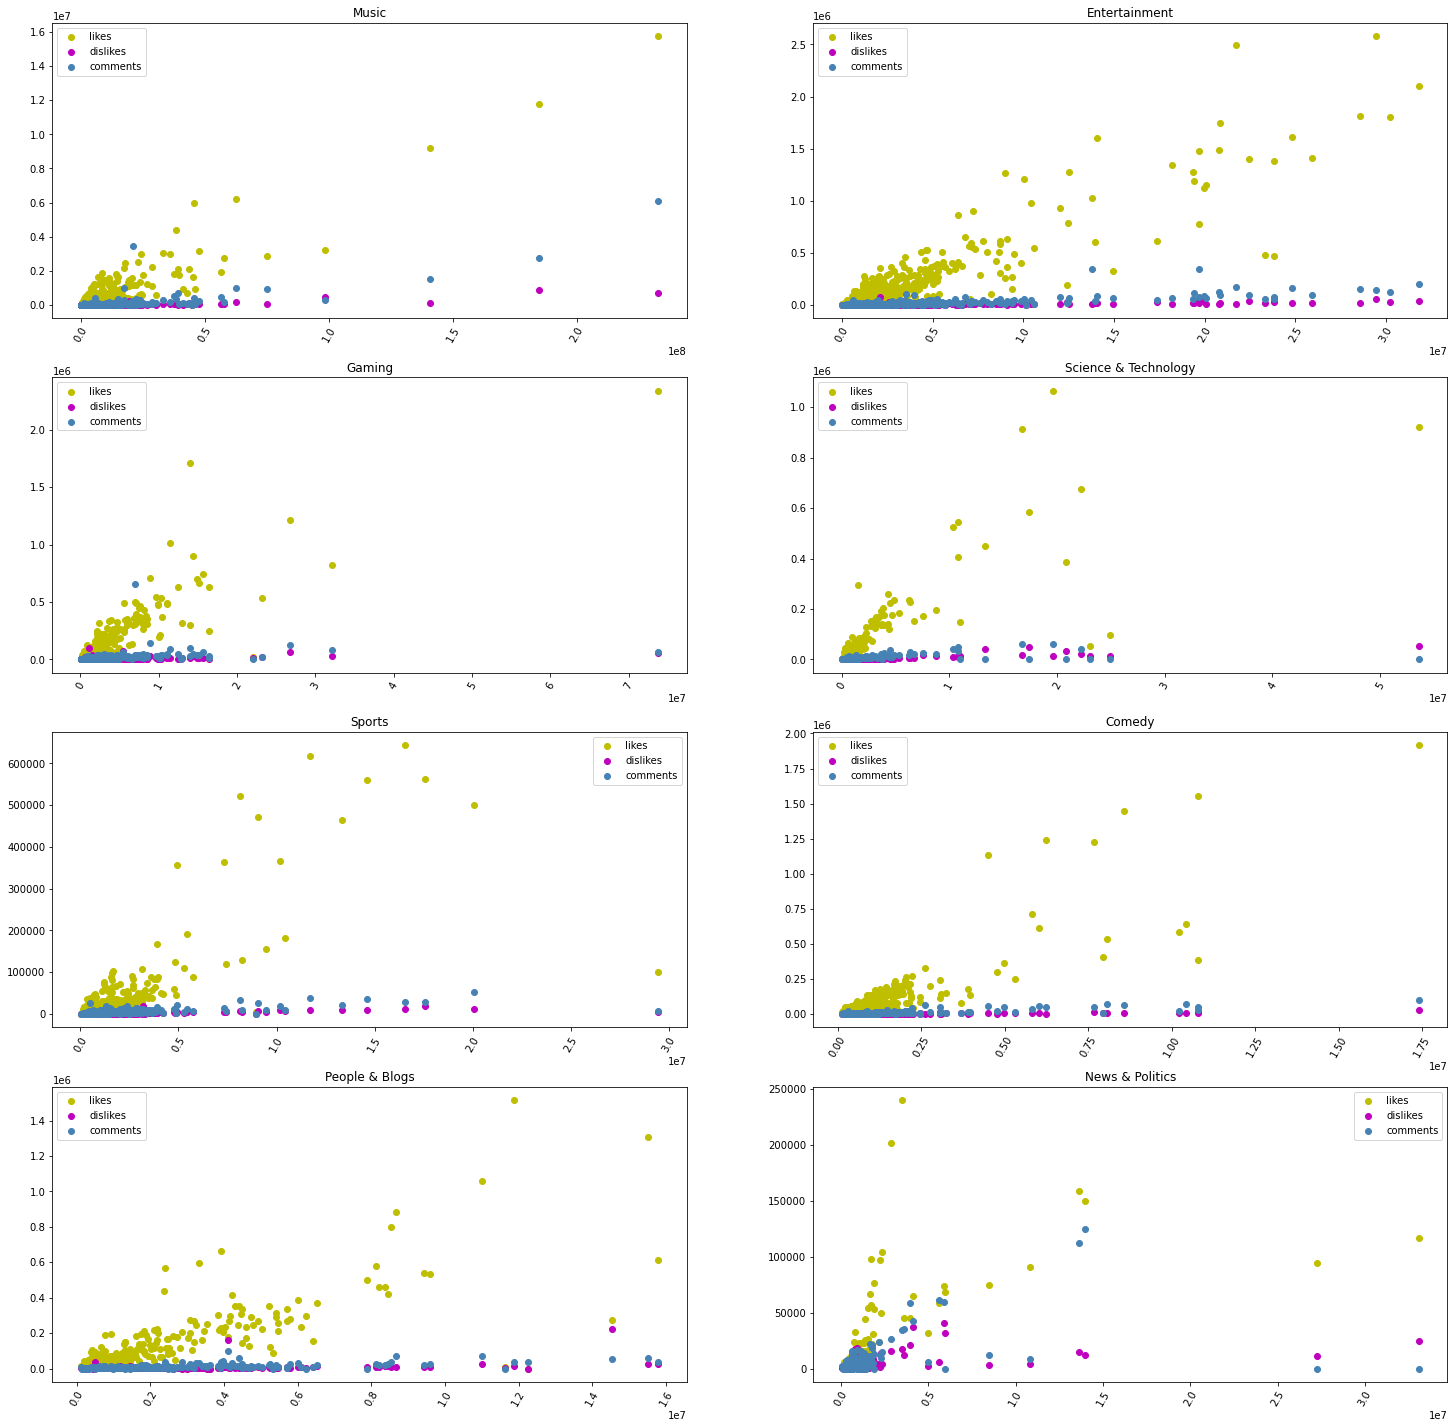

In [32]:
#subplots initilizer
fig, (ax) = plt.subplots(2, figsize=(25, 25))
#supplot 1
#initialize
df = youtube_data
#filter
df=df[df['category']=='Music']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 1)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Music')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 2
#initialize
df = youtube_data
#filter
df=df[df['category']=='Entertainment']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 2)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Entertainment')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 3
#initialize
df = youtube_data
#filter
df=df[df['category']=='Gaming']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 3)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Gaming')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 4
#initialize
df = youtube_data
#filter
df=df[df['category']=='Science & Technology']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 4)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Science & Technology')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 5
#initialize
df = youtube_data
#filter
df=df[df['category']=='Sports']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 5)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Sports')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 6
#initialize
df = youtube_data
#filter
df=df[df['category']=='Comedy']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 6)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='Comedy')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 7
#initialize
df = youtube_data
#filter
df=df[df['category']=='People & Blogs']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 7)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='People & Blogs')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)

#subplot 8
#initialize
df = youtube_data
#filter
df=df[df['category']=='News & Politics']
#subplot (rows, columns, locate)
ax = plt.subplot(4, 2, 8)
ax.scatter(df['views'], df['likes'], color='y')
ax.scatter(df['views'], df['dislikes'], color='m')
ax.scatter(df['views'], df['comments'], color='steelblue')
ax.set(title='News & Politics')
ax.legend(['likes', 'dislikes', 'comments'])
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60)
plt.show()

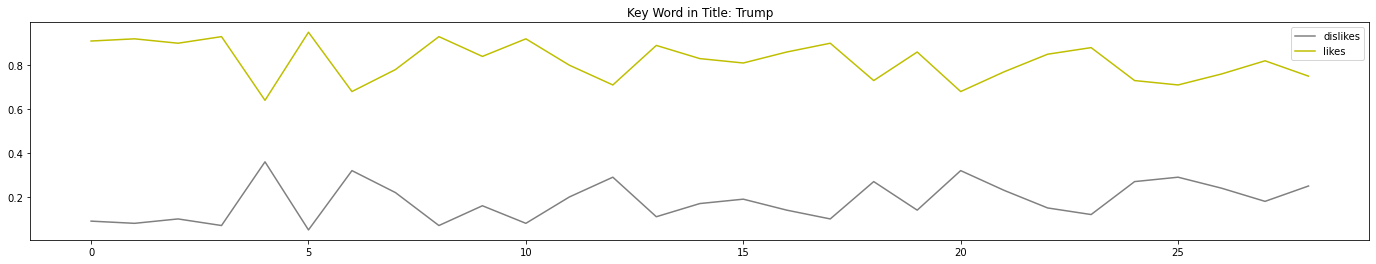

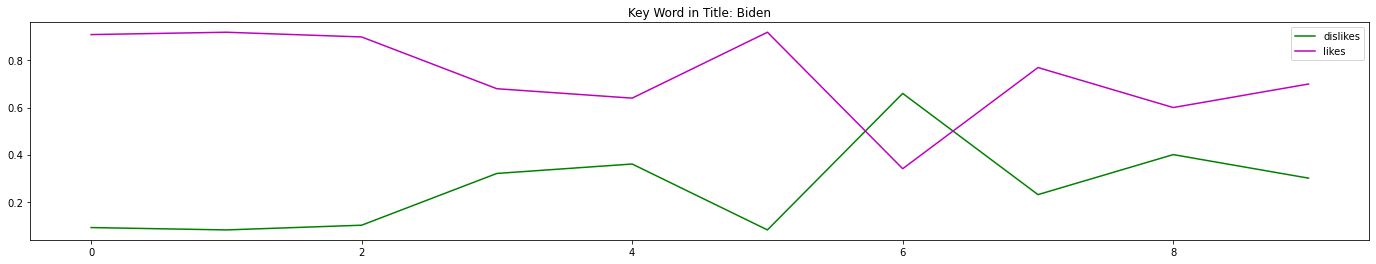

In [56]:
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#subplot 1
#initialize
df = youtube_data
#category filter
df=df[df['category']=='News & Politics']
#title filter: searches for key words in titles
df=df[df['title'].apply(lambda x : re.search('trump',x.lower()) !=None)]
#subplot x= 0 to lenght of dataframe, y= percent of like or dislike
ax.plot(range(len(df['per_dislikes'])), df['per_dislikes'], c='gray')
ax.plot(range(len(df['per_likes'])), df['per_likes'], c='y')
ax.legend(['dislikes', 'likes'])
ax.set(title='Key Word in Title: Trump')

#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#subplot 2
#initialize
df = youtube_data
#category filter
df=df[df['category']=='News & Politics']
#title filter: searches for key words in titles
df=df[df['title'].apply(lambda x : re.search('biden',x.lower()) !=None)]
#subplot x= 0 to lenght of dataframe, y= percent of like or dislike
ax.plot(range(len(df['per_dislikes'])), df['per_dislikes'], c='g')
ax.plot(range(len(df['per_likes'])), df['per_likes'], c='m')
ax.legend(['% dislikes', '% likes'])
ax.set(title='Key Word in Title: Biden')
plt.show()

In [ ]:
#User input key term search
#subplots initilizer
fig, (ax) = plt.subplots(1, figsize=(24, 4))
#subplot 2
#initialize
df = youtube_data
#category filter
#title filter: searches for key words in titles user input
input_term = input(f'Enter a term to view percentage of likes and dislikes')

df=df[df['title'].apply(lambda x : re.search(input_term,x.lower()) !=None)]
#subplot
ax.plot(range(len(df['per_dislikes'])), df['per_dislikes'], c='g')
ax.plot(range(len(df['per_likes'])), df['per_likes'], c='m')
ax.legend(['dislikes', 'likes'])
ax.set(title=f'Key Word in Title: {input_term}')
plt.show()

In [ ]:
#export clean data
#youtube_data.to_csv("youtube_data.csv", index=False, header=True)